In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

## __1 - Business Problem__  
___Forecast the Plastic sales data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting___  

## __2 - Data collection and description__ 

In [2]:
df = pd.read_csv("PlasticSales.csv")

In [3]:
df1 = df.copy()

In [4]:
df1.head()

Month  Sales
0  Jan-49    742
1  Feb-49    697
2  Mar-49    776
3  Apr-49    898
4  May-49   1030

In [5]:
df1.isnull().sum()

Month    0
Sales    0
dtype: int64

In [6]:
df1.dtypes

Month    object
Sales     int64
dtype: object

In [7]:
df1.describe().T

count         mean         std    min     25%     50%     75%     max
Sales   60.0  1162.366667  266.431469  697.0  947.75  1148.0  1362.5  1637.0

In [36]:
dt = pd.to_datetime(df1.Month.str.replace(r'(M\d)_(\d+)', r'\2-\1'))

In [39]:
dt = (dt.where(dt <= pd.to_datetime('today'), dt - pd.DateOffset(years=100)).dt.strftime('%b-%Y'))

In [40]:
df1['month'] = pd.to_datetime(dt).dt.strftime('%m-%Y')

In [41]:
df1.head()

Month  Sales    month
0  Jan-49    742  01-1949
1  Feb-49    697  02-1949
2  Mar-49    776  03-1949
3  Apr-49    898  04-1949
4  May-49   1030  05-1949

In [42]:
df1 = df1.drop(['Month'], axis=1)

In [43]:
df1.reset_index(inplace=True)

In [45]:
df1['month'] = pd.to_datetime(df1['month'])

In [46]:
df1 = df1.set_index('month')

In [47]:
df1.head()

index  Sales
month                   
1949-01-01      0    742
1949-02-01      1    697
1949-03-01      2    776
1949-04-01      3    898
1949-05-01      4   1030

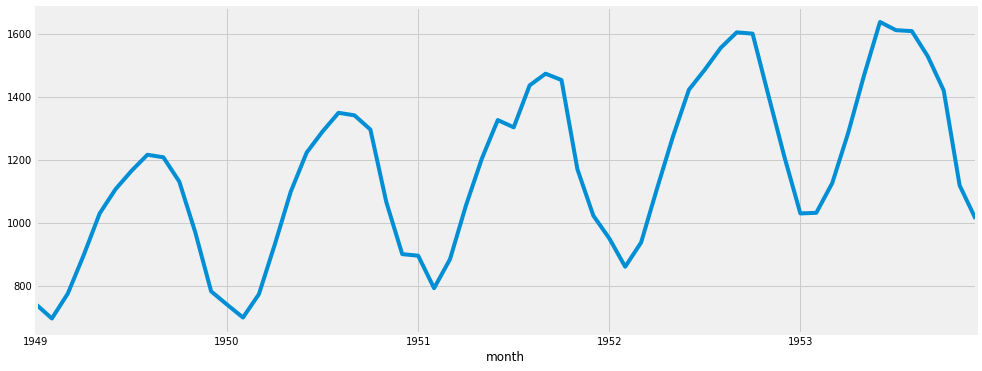

In [48]:
df1['Sales'].plot(figsize=(15, 6))
plt.show()

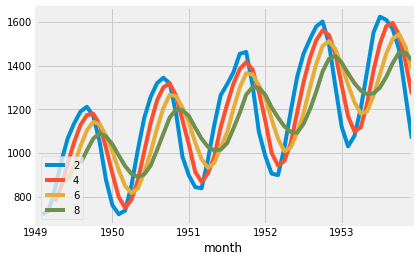

In [49]:
for i in range(2,10,2):
    df1["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

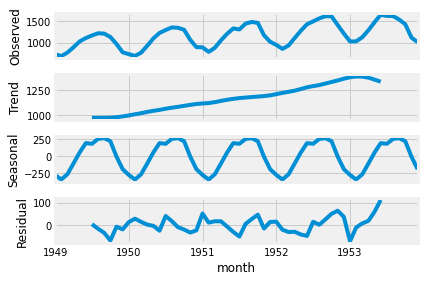

In [50]:
ts_add = seasonal_decompose(df1.Sales,model="additive")
fig = ts_add.plot()
plt.show()

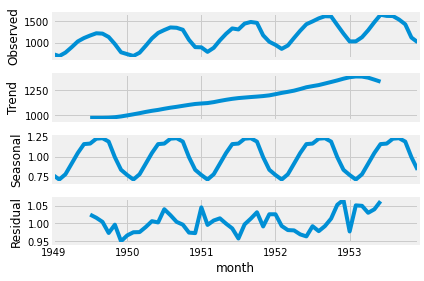

In [51]:
ts_mul = seasonal_decompose(df1.Sales,model="multiplicative")
fig = ts_mul.plot()
plt.show()

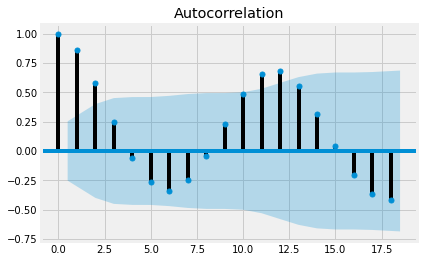

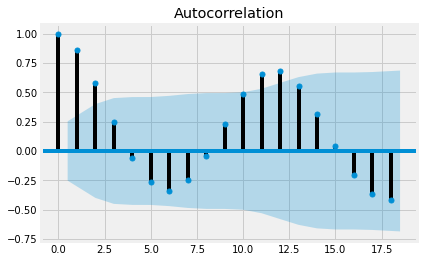

In [52]:
tsa_plots.plot_acf(df1.Sales)

## __3 - Building Time series forecasting with ARIMA__ 

In [53]:
X = df1['Sales'].values

In [54]:
size = int(len(X) * 0.66)

In [55]:
train, test = X[0:size], X[size:len(X)]

In [56]:
model = ARIMA(train, order=(5,1,0))

In [57]:
model_fit = model.fit(disp=0)

In [58]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   38
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -219.880
Method:                       css-mle   S.D. of innovations             76.872
Date:                Sat, 20 Jun 2020   AIC                            453.759
Time:                        17:05:10   BIC                            465.222
Sample:                             1   HQIC                           457.838
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3571     13.542      0.543      0.591     -19.184      33.898
ar.L1.D.y      0.4823      0.152      3.179      0.003       0.185       0.780
ar.L2.D.y      0.0549      0.175      0.314      0.7

### This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations

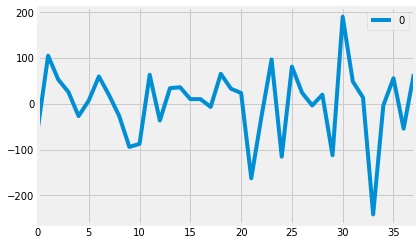

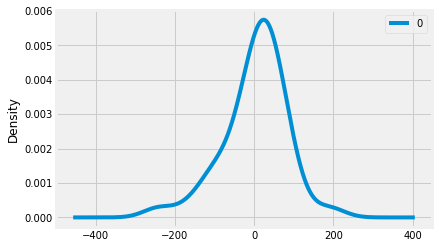

                0
count   38.000000
mean     2.357854
std     78.886080
min   -241.421435
25%    -27.938592
50%     16.358842
75%     51.798923
max    190.076624


In [59]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

### The plot of the residual errors suggests that there may still be some trend information not captured by the model  
### The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals)  

### __3.1 - Rolling Forecast ARIMA Model__ 

In [60]:
history = [x for x in train]

In [61]:
predictions = list()

In [62]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=1094.210170, expected=1109.000000
predicted=1265.772401, expected=1274.000000
predicted=1405.233696, expected=1422.000000
predicted=1525.380355, expected=1486.000000
predicted=1473.882998, expected=1555.000000
predicted=1516.980044, expected=1604.000000
predicted=1571.453228, expected=1600.000000
predicted=1557.117519, expected=1403.000000
predicted=1278.688427, expected=1209.000000
predicted=1076.916946, expected=1030.000000
predicted=923.452151, expected=1032.000000
predicted=1071.113244, expected=1126.000000
predicted=1285.998656, expected=1285.000000
predicted=1461.754866, expected=1468.000000
predicted=1628.764807, expected=1637.000000
predicted=1719.017017, expected=1611.000000
predicted=1539.508686, expected=1608.000000
predicted=1527.679374, expected=1528.000000
predicted=1421.859015, expected=1420.000000
predicted=1317.593593, expected=1119.000000
predicted=978.328236, expected=1013.000000


In [63]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 5704.879


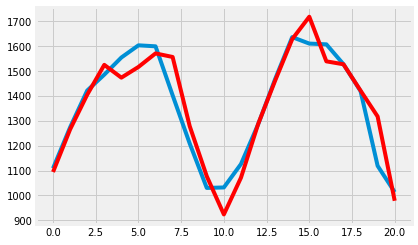

In [64]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale  

## __4 - Comparing Multiple Models__ 

In [93]:
df2 = df1.copy()

In [94]:
df2.head()

index  Sales
month                   
1949-01-01      0    742
1949-02-01      1    697
1949-03-01      2    776
1949-04-01      3    898
1949-05-01      4   1030

In [95]:
df2['Month'] = pd.DatetimeIndex(df['Month']).month

In [96]:
df2.head()

index  Sales  Month
month                          
1949-01-01      0    742      1
1949-02-01      1    697      2
1949-03-01      2    776      3
1949-04-01      3    898      4
1949-05-01      4   1030      5

In [98]:
df2 = pd.get_dummies(df2, columns = ['Month'])

In [99]:
df2.head()

index  Sales  Month_1  Month_2  Month_3  Month_4  Month_5  \
month                                                                   
1949-01-01      0    742        1        0        0        0        0   
1949-02-01      1    697        0        1        0        0        0   
1949-03-01      2    776        0        0        1        0        0   
1949-04-01      3    898        0        0        0        1        0   
1949-05-01      4   1030        0        0        0        0        1   

            Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  Month_12  
month                                                                         
1949-01-01        0        0        0        0         0         0         0  
1949-02-01        0        0        0        0         0         0         0  
1949-03-01        0        0        0        0         0         0         0  
1949-04-01        0        0        0        0         0         0         0  
1949-05-01        0        0        0        0         0         0         0

In [100]:
df2.shape

(60, 14)

In [101]:
t= np.arange(1,61)

In [102]:
df2['t'] = t

In [103]:
df2['t_sq'] = df2['t']*df2['t']

In [104]:
log_Sales=np.log(df2['Sales'])

In [105]:
df2['log_Sales']=log_Sales

In [106]:
df2.head()

index  Sales  Month_1  Month_2  Month_3  Month_4  Month_5  \
month                                                                   
1949-01-01      0    742        1        0        0        0        0   
1949-02-01      1    697        0        1        0        0        0   
1949-03-01      2    776        0        0        1        0        0   
1949-04-01      3    898        0        0        0        1        0   
1949-05-01      4   1030        0        0        0        0        1   

            Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  Month_12  \
month                                                                          
1949-01-01        0        0        0        0         0         0         0   
1949-02-01        0        0        0        0         0         0         0   
1949-03-01        0        0        0        0         0         0         0   
1949-04-01        0        0        0        0         0         0         0   
1949-05-01        0        0        0        0         0         0         0   

            t  t_sq  log_Sales  
month                           
1949-01-01  1     1   6.609349  
1949-02-01  2     4   6.546785  
1949-03-01  3     9   6.654153  
1949-04-01  4    16   6.800170  
1949-05-01  5    25   6.937314

In [107]:
train1, test1 = np.split(df2, [int(.67 *len(df2))])

In [108]:
linear= smf.ols('Sales ~ t',data=train1).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test1['t'])))
rmselin=np.sqrt((np.mean(np.array(test1['Sales'])-np.array(predlin))**2))
rmselin

112.86885553470945

In [109]:
quad=smf.ols('Sales~t+t_sq',data=train1).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test1[['t','t_sq']])))
rmsequad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predquad))**2))
rmsequad

495.46688215145764

In [110]:
expo=smf.ols('log_Sales~t',data=train1).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test1['t'])))
rmseexpo=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo

250.10705706123244

In [111]:
additive= smf.ols('Sales~ Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12',data=train1).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test1[['Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']])))
rmseadd=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predadd))**2))
rmseadd

263.23620175930745

In [112]:
addlinear= smf.ols('Sales~t+Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12',data=train1).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test1[['t','Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']])))
rmseaddlinear=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear

105.24683124023927

In [113]:
addquad=smf.ols('Sales~t+t_sq+Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12',data=train1).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test1[['t','t_sq','Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']])))
rmseaddquad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddquad))**2))
rmseaddquad

118.23685739814073

In [114]:
mulsea=smf.ols('log_Sales~Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12',data=train1).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test1[['Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']])))
rmsemul= np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul

266.6198308649414

In [115]:
mullin= smf.ols('log_Sales~t+Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12',data=train1).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test1[['t','Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']])))
rmsemulin=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin

117.11496871634851

In [116]:
mul_quad= smf.ols('log_Sales~t+t_sq+Month_1+Month_2+Month_3+Month_4+Month_5+Month_6+Month_7+Month_8+Month_9+Month_10+Month_11+Month_12',data=train1).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test1[['t','t_sq','Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

178.01911242659176

## __5 - Conclusion__ 

In [117]:
output = {'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),
          'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}

In [118]:
rmse=pd.DataFrame(output)

In [119]:
print(rmse)

           Model      Values
0  rmse_mul_quad  178.019112
1        rmseadd  263.236202
2  rmseaddlinear  105.246831
3    rmseaddquad  118.236857
4       rmseexpo  250.107057
5        rmselin  112.868856
6        rmsemul  266.619831
7      rmsemulin  117.114969
8       rmsequad  495.466882


### Multiplicative seasonality with linear trend has the best RMSE value